In [7]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [9]:
train_dataset = datasets.ImageFolder(root='train 70001', transform=transform)
val_dataset = datasets.ImageFolder(root='Validation 19000', transform=transform)
test_dataset = datasets.ImageFolder(root='test 5413', transform=transform)


In [10]:
# def get_subset(dataset, percentage=0.1):
#     total_size = len(dataset)
#     subset_size = int(percentage * total_size)
#     _, subset = random_split(dataset, [total_size - subset_size, subset_size])
#     return subset

from torch.utils.data import Subset
import random

def get_subset(dataset, num_images):
    # Ensure num_images does not exceed the size of the dataset
    if num_images > len(dataset):
        raise ValueError(f"Requested {num_images} images, but dataset only has {len(dataset)} images.")
    
    # Get random indices from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    
    # Return the subset
    return Subset(dataset, indices)

In [11]:
train_subset = get_subset(train_dataset, num_images=500)
val_subset = get_subset(val_dataset, num_images=500)
test_subset = get_subset(test_dataset, num_images=500)

In [12]:
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [13]:
import torchvision.models as models
import torch.nn as nn
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: real vs fake

C:\Users\prith\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prith\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%')


Epoch [1/10], Loss: 0.7816314612116132, Accuracy: 62.5%
Epoch [2/10], Loss: 0.6180171689816883, Accuracy: 72.0%
Epoch [3/10], Loss: 0.426321165902274, Accuracy: 81.5%
Epoch [4/10], Loss: 0.28621406640325275, Accuracy: 85.0%
Epoch [5/10], Loss: 0.1493801325559616, Accuracy: 97.0%
Epoch [6/10], Loss: 0.06672293692827225, Accuracy: 98.5%
Epoch [7/10], Loss: 0.12936309219471046, Accuracy: 97.5%
Epoch [8/10], Loss: 0.08341950231364795, Accuracy: 98.5%
Epoch [9/10], Loss: 0.1488649874393429, Accuracy: 96.5%
Epoch [10/10], Loss: 0.17513988805668695, Accuracy: 95.0%


In [18]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Store labels and predictions for advanced metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())



In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
accuracy = 100 * correct / total

# Compute advanced metrics
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the evaluation metrics
print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Validation Loss: 2.4940, Validation Accuracy: 61.00%
Precision: 0.6964, Recall: 0.6665, F1-Score: 0.6052
Confusion Matrix:
[[36  3]
 [36 25]]


In [20]:
torch.save(model.state_dict(), 'deepfake_model_resnet50.pth')


C:\Users\prith\AppData\Local\Temp\ipykernel_26768\2974120982.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deepfake_model_resnet50.p

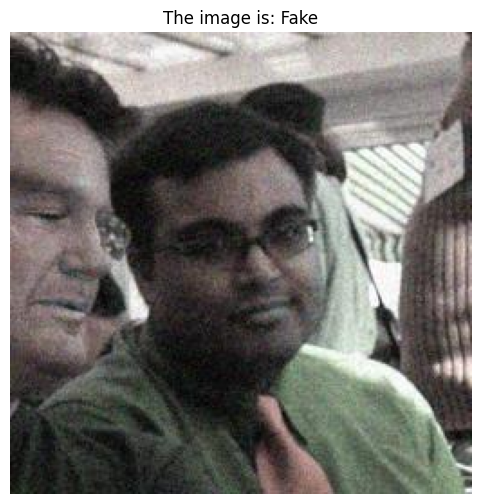

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: real vs fake
model.load_state_dict(torch.load('deepfake_model_resnet50.pth'))
model = model.to(device)
model.eval()

# Define the function to make predictions and display the image
def predict_and_show_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    # Map the prediction to class names
    class_names = ['Fake', 'Real']  # Assuming '0' is 'Fake' and '1' is 'Real'
    predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f'The image is: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'test_sample_100/real/real_92.jpg'
predict_and_show_image(image_path)
